In [1]:
import glob, os
from stellar_libs import setup_miles_library, load_bc03_library
import ppxf_util as util
import  numpy as np
from ppxf import ppxf, reddening_curve
from astropy import constants

import fors2_util

import matplotlib.pyplot as plt
import pickle
%matplotlib inline

First, the BC03 library is loaded, and an output directory is defined for the outputs.

In [2]:
bc03_path = "./BasesDir"
selection_file = "./Base.BC03.N"
outdir='output_bc03s'
if not os.path.exists(outdir):
    os.mkdir(outdir)

bc03_lambda, bc03, logAges, metals = fors2_util.load_bc03(bc03_path, selection_file)

Next, a galaxy to be fit is chosen. It is expected to be 2-column : wavelength in angstrom and flux in arbitrary units. PPXF requires the templates and galaxy spectra to be log rebinned, for the kinematic fit to be correct. PPXF provides the log_rebin facility to that purpose. The resulting velocity scale is just :
$$
\frac{dv}{c} = \frac{d\lambda}{\lambda} = d\log{\lambda}
$$

SPEC029Abright
galaxy sampling in lin : [ 2.597  2.597  2.597 ...,  2.597  2.597  2.597]
galaxy sampling in log : [ 0.00074464  0.00074409  0.00074354 ...,  0.0003768   0.00037666
  0.00037652]
ppxf requires that the input be rebinned in log
velocity scale from the galaxy:  [ 155.7244218]


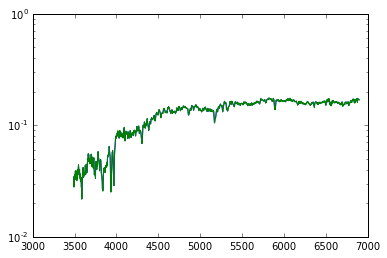

In [3]:
galaxy_filename = '../data/txt/SPEC029Abright.txt'
title = galaxy_filename.split('/')[-1].split('.txt')[0]
print title

galaxy_data = np.loadtxt(galaxy_filename, dtype={'names':('wavelength', 'flux'),'formats':('float', 'float')})
flux=galaxy_data['flux']
wave=galaxy_data['wavelength']

print "galaxy sampling in lin :",np.diff(wave)
print "galaxy sampling in log :",np.diff(np.log(wave))
print 'ppxf requires that the input be rebinned in log'
new_flux, log_wave, velscale = util.log_rebin([wave[0],wave[-1]], flux)
plt.semilogy(np.exp(log_wave), new_flux)
plt.semilogy(wave, flux)
#dv/c = dlambda/lambda = dlog(lambda)
#velscale=np.log(wave[1]/wave[0])*constants.c
print 'velocity scale from the galaxy: ',velscale
new_wave = np.exp(log_wave)

One can see in the figure above that the two curves are virtually indistinguishable.
Next, we need to log-rebin to the same binning the spectra. Furthermore, a smoothing step ensures that the resolution of the galaxy and the templates are commensurable.

In [4]:
FWHM_gal=4
FWHM_tem=3 # According to BC03, this is the FWHM of the STELIB atlas.

templates = fors2_util.smooth_and_rebin(bc03, bc03_lambda, new_wave, velscale, FWHM_gal, FWHM_tem)

For ease of use, we rescale all the spectra to the median value

In [5]:
#normalize everyone
norm=np.median(templates)
templates /= norm
bc03 /= norm
galaxy = new_flux / np.median(new_flux)

Finally, we define the inputs to PPXF and we create the class instance, which automatically performs the fit. The file ppxf.py explains a lot fo these inputs.

In [6]:
# noise in the galaxy spectrum (so error on flux estimates)
noise = galaxy*0.1 + 1.e-3 #need to put a realistic value here

#dv = constants.c*np.log(lamRange_temp[0]/wave[0])  # km/s
#by costruction there is no need for a systematic shift here, as when we logrebinned the templates we realigned
#them to the wavelength array of the galaxy
dv = 0
z=0 # no redshift

#mask some notorious lines and atmospheric systems
goodpixels = util.determine_goodpixels(log_wave, [new_wave[0], new_wave[-1]], z)

# v and sigma to be fitted, with the following starting values
start = [constants.c.value*np.log(1 + z), 3*velscale]
#fixed = [True, True]#, False, False]
fixed = [False, False]        
pp = ppxf(templates, galaxy, noise, velscale, start,
    goodpixels=goodpixels, plot=False, moments=2, degree=-1,
    vsyst=dv, clean=False, regul=1,
    mdegree=0, reddening=0.1,lam=new_wave,
    fixed=fixed
    )

Best Fit:       Vel     sigma
 comp. 0:        42       261
chi2/DOF: 0.1577
Function evaluations: 20 Status: 1
Reddening E(B-V): 0.0395
Nonzero Templates:  9  /  45


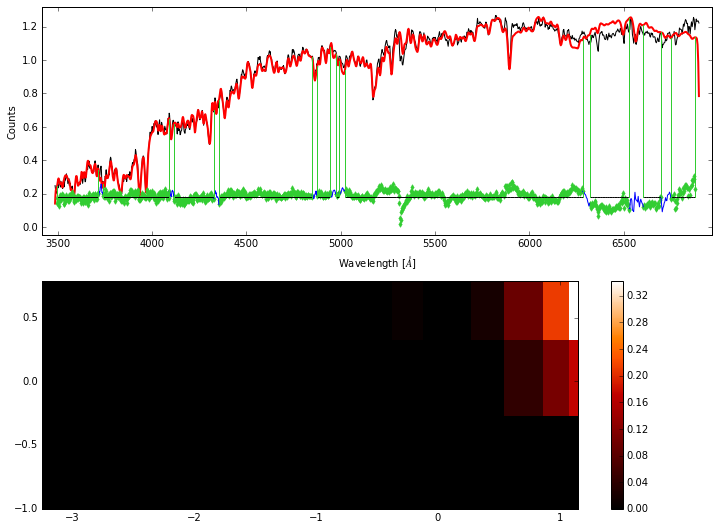

In [7]:
fig = plt.figure(figsize=(12,9))
ax0 = fig.add_subplot(211)
pp.plot()
ax02 = fig.add_subplot(212)
nAges, nMetal = templates.shape[1:]
weights = pp.weights.reshape(nAges, nMetal)/pp.weights.sum() 
fors2_util.plot_weights(weights, logAges, metals, cmap='gist_heat', nodots=True)

Desired Delta Chi^2: 48.89
Current Delta Chi^2: -1007


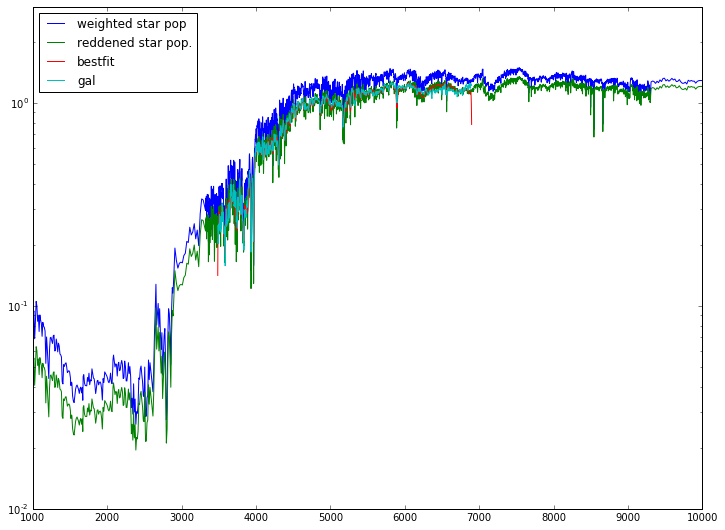

In [8]:
print('Desired Delta Chi^2: %.4g' % np.sqrt(2*goodpixels.size))
print('Current Delta Chi^2: %.4g' % ((pp.chi2 - 1)*goodpixels.size))


ax2 = plt.figure(figsize=(12,9)).add_subplot(111)
pop_spectrum = np.dot(bc03.reshape((bc03.shape[0],bc03.shape[1]*bc03.shape[2])),pp.weights)
ax2.semilogy(bc03_lambda, pop_spectrum, label='weighted star pop')

red_curve = reddening_curve(bc03_lambda, pp.reddening)
reddened = pop_spectrum*red_curve
ax2.semilogy(bc03_lambda, reddened, label='reddened star pop.')
ax2.semilogy(new_wave, pp.bestfit, label='bestfit')

ax2.semilogy(new_wave, galaxy, label='gal')
ax2.legend(loc=2)
ax2.set_xlim(1000, 10000)
ax2.set_ylim(0.01, 2*pop_spectrum.max())
plt.savefig(os.path.join(outdir,title+'_full.png'))

np.savetxt(os.path.join(outdir,title+'_unreddened_sed.txt'), np.transpose([bc03_lambda,pop_spectrum]), fmt=('%.1f','%.5e'), delimiter=' ', newline=os.linesep)

